In [2]:
import pandas as pd
import numpy as np
from functools import reduce
from collections import Counter

In [3]:
df = pd.read_csv('appen/output_batch_correct_v5/query_attribution_till_032423_valid_units.csv')

In [4]:
assert len(df) == len(set(df['label_ordering']))

In [5]:
df_attributes = pd.read_csv('../attribute_extraction_metadata_template/attribute_definition_top25L2_filtered_augmented_redacted_addedsinglemulti_01182023.csv')

In [6]:
df_attributes_orig = pd.read_csv('../attribute_extraction_metadata_template/Initial Attribute Definition for First Release - UPDATED SHEET .csv')

In [7]:
cats = set(df_attributes['category'])

In [8]:
df_attributes_orig_sub = df_attributes_orig[
    (df_attributes_orig.category.apply(lambda x: x in cats)) & (df_attributes_orig['entry mode'].apply(lambda x: x != 'free_text'))
]

In [9]:
df_attributes_orig_sub_group = df_attributes_orig_sub[['attribute_field', 'category_attributevalue']].groupby('attribute_field').agg({
    'category_attributevalue': lambda x: sorted(set(reduce(lambda x, y: x+y, [[str(j) for j in eval(i)] for i in x])))
}).reset_index()

In [10]:
df_attributes_orig_sub_group

,attribute_field,category_attributevalue
0,Adjustable Fit,"[Chest Adjustment, Hip Adjustment, Shoulder Ad..."
1,Adjustable Length,"[No, Yes]"
2,Age Range Description,"[Adult, All Ages, Infant, Kids, Teen, Toddler]"
3,Alarm Type,"[Beep Alarm, Bell Alarm, Gradual Alarm, Loud A..."
4,Alert Type,"[Audio Only, Audio and Motion, Motion Only]"
...,...,...
188,Wall Light Type,"[Candelabra, Reading, Swing Arm, Wall Lamp, Wa..."
189,Watch Movement Type,"[Analog Quartz, Automatic, Automatic Self Wind..."
190,Water Resistance Level,"[Not Water-Resistant, Water-Resistant, Waterpr..."
191,Weave Type,"[Basket, Braided, Dobby, Double Cloth, Flat Wo..."


In [11]:
df_attributes_group = df_attributes.groupby('attribute_field').agg({
    'category_attributevalue': lambda x: sorted(set(reduce(lambda x, y: x+y, [[str(j) for j in eval(i)] for i in x])))
}).reset_index()

In [12]:
df_attributes_group

,attribute_field,category_attributevalue
0,Absorption,"[High, Low, Medium, No Absorption, None]"
1,Additional Accessories,"[Coaster, Lid, None, Saucer, Spoon, Straw]"
2,Adjustable Fit,"[Chest Adjustment, Hip Adjustment, Shoulder Ad..."
3,Adjustable Length,"[No, Yes]"
4,Age Range Description,"[Adult, All Ages, Infant, Kids, Teen, Toddler]"
...,...,...
225,Wall Light Type,"[Candelabra, Reading, Swing Arm, Wall Lamp, Wa..."
226,Watch Movement Type,"[Analog Quartz, Automatic, Automatic Self Wind..."
227,Water Resistance Level,"[Not Water-Resistant, Water-Resistant, Waterpr..."
228,Weave Type,"[Basket, Braided, Dobby, Double Cloth, Flat Wo..."


In [13]:
attr_vals_normalized = {}
for i in df_attributes_group.to_dict('records'):
    attr_vals_normalized[i['attribute_field']] = set(i['category_attributevalue'])

attr_vals_orig_normalized = {}
for i in df_attributes_orig_sub_group.to_dict('records'):
    attr_vals_orig_normalized[i['attribute_field']] = set(i['category_attributevalue'])

In [14]:
all_kvpairs = set()
all_orig_kvpairs = set()

for k in attr_vals_normalized:
    for v in attr_vals_normalized[k]:
        all_kvpairs.add((k, v))

for k in attr_vals_orig_normalized:
    for v in attr_vals_orig_normalized[k]:
        all_orig_kvpairs.add((k, v))

In [15]:
len(attr_vals_normalized), len(attr_vals_orig_normalized)

(230, 193)

In [16]:
len(all_kvpairs), len(all_orig_kvpairs)

(13592, 6875)

In [18]:
i

{'label_ordering': 225,
 'sample_method': 'head',
 'l2_category': 'Home & Garden > Arts, Crafts & Sewing',
 'query_category': 'Home & Garden > Arts, Crafts & Sewing > Button & Badge Making > Maker Molds',
 'rater_output': 'Home & Garden > Arts, Crafts & Sewing > Pottery & Ceramics > Clay Molds > Materials > Silicone\nHome & Garden > Arts, Crafts & Sewing > Pottery & Ceramics > Clay Molds > Pattern > 3D',
 'query': 'molde gesso 3d silicone',
 'translated_query': nan,
 'no_attributes': nan,
 'unlisted_value': nan}

In [19]:
recs = []
for i in df.to_dict('records'):
    res_normalized = []
    res_custom = []
    res = [] if ((not isinstance(i['rater_output'], str)) and (np.isnan(i['rater_output']))) else i['rater_output'].split('\n')
    for j in res:
        k, v = j.split(' > ')[-2:]
        assert k in attr_vals_normalized
        if k in attr_vals_orig_normalized and v in attr_vals_orig_normalized[k]:
            res_normalized.append((k, v))
        else:
            res_custom.append((k, v))
    i['attr_name_value_pairs_normalized'] = sorted(set(res_normalized))
    i['attr_name_value_pairs_custom'] = sorted(set(res_custom))
    recs.append(i)
df = pd.DataFrame(recs)

In [20]:
df['attr_name_value_pairs_normalized'].apply(len).mean(), df['attr_name_value_pairs_custom'].apply(len).mean()

(0.5428738090608595, 0.16637809443564838)

<Axes: ylabel='Frequency'>

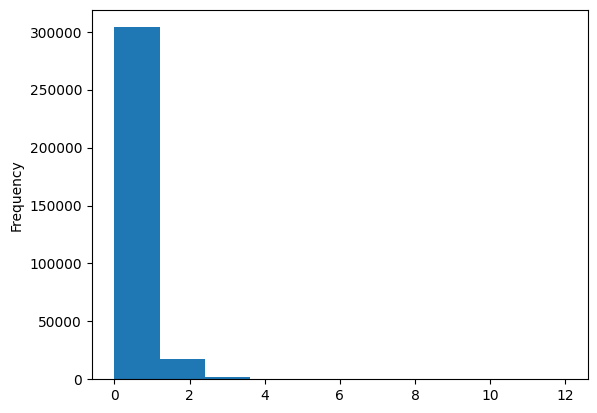

In [21]:
df['attr_name_value_pairs_normalized'].apply(len).plot.hist()

<Axes: ylabel='Frequency'>

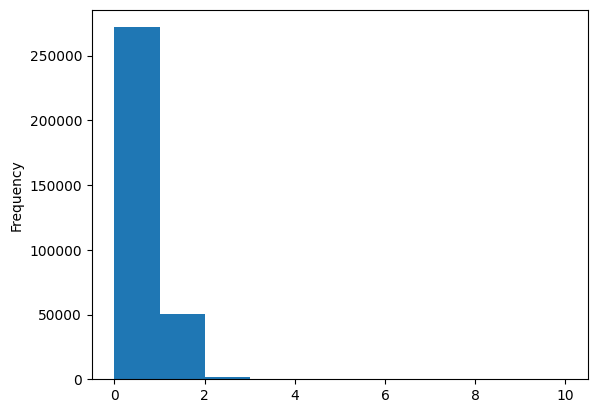

In [22]:
df['attr_name_value_pairs_custom'].apply(len).plot.hist()

In [23]:
normalized_attributes = reduce(lambda x,y: x+y, df['attr_name_value_pairs_normalized'].apply(lambda x: [i[0] for i in x]))
custom_attributes = reduce(lambda x,y: x+y, df['attr_name_value_pairs_custom'].apply(lambda x: [i[0] for i in x]))

In [24]:
normalized_kvpairs = reduce(lambda x,y: x+y, df['attr_name_value_pairs_normalized'])
custom_kvpairs = reduce(lambda x,y: x+y, df['attr_name_value_pairs_custom'])

In [25]:
len(set(normalized_attributes)), len(set(custom_attributes))

(168, 123)

In [26]:
len(set(normalized_kvpairs)), len(set(custom_kvpairs))

(3112, 10269)

In [27]:
Counter(normalized_attributes).most_common(5)

[('Department', 34169),
 ('Primary Color', 26199),
 ('Materials', 24954),
 ('Theme', 14008),
 ('Brand', 11108)]

In [28]:
Counter(custom_attributes).most_common(5)

[('Brand', 14491),
 ('Item Types', 12558),
 ('Brand Name', 10821),
 ('Use', 4046),
 ('Theme', 2743)]

In [29]:
Counter(normalized_kvpairs).most_common(5)

[(('Department', 'Women'), 15519),
 (('Department', 'Men'), 9587),
 (('Brand', 'Samsung'), 8204),
 (('Primary Color', 'Black'), 6135),
 (('Department', 'Dogs'), 4533)]

In [30]:
Counter(custom_kvpairs).most_common(5)

[(('Brand', 'Apple'), 4566),
 (('Brand', 'apple'), 2864),
 (('Brand Name', 'Nike'), 2355),
 (('Brand', 'huawei'), 1012),
 (('Use', 'Smoking'), 808)]

In [31]:
len(set(normalized_attributes)) / len(attr_vals_orig_normalized) # normalized original no free-text

0.8704663212435233

In [32]:
len(set(custom_attributes).union(set(normalized_attributes))) / len(attr_vals_normalized) # add in augmented free-text attributes

0.8608695652173913

In [33]:
len(set(normalized_kvpairs).intersection(all_orig_kvpairs)) / len(all_orig_kvpairs) # normalized original no free-text

0.4526545454545455

In [34]:
len((set(normalized_kvpairs).union(custom_kvpairs)).intersection(all_kvpairs)) / len(all_kvpairs) # add in augmented free-text attributes

0.3410829899941142

In [35]:
any(['|' in i[0] for i in all_kvpairs]), any(['|' in i[1] for i in all_kvpairs]), any(['\n' in i[0] for i in all_kvpairs]), any(['\n' in i[1] for i in all_kvpairs])

(False, False, False, False)

In [36]:
df['attr_name_value_pairs_normalized_text'] = df['attr_name_value_pairs_normalized'].apply(lambda x: '\n'.join([i[0] + '|' + i[1] for i in x]))

In [41]:
df_out = df[['label_ordering', 'sample_method', 'query', 'query_category', 'rater_output', 'attr_name_value_pairs_normalized', 
    'attr_name_value_pairs_custom', 'attr_name_value_pairs_normalized_text']]

<Axes: ylabel='Frequency'>

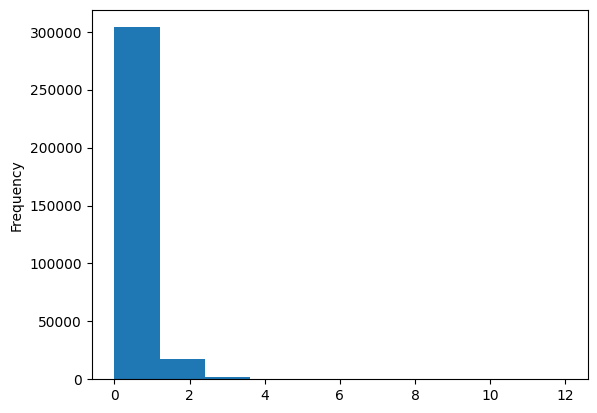

In [44]:
df_out.attr_name_value_pairs_normalized.apply(len).plot.hist()

In [45]:
len(set(df_out['query'])), len(df_out)

(324005, 324009)

In [46]:
len(set(df_out['label_ordering'])), len(df_out)

(324009, 324009)

In [52]:
tmp = Counter(df_out['query'])
[i for i in tmp if tmp[i] > 1]

['cosas de marihuana',
 'women’s winter boots',
 'outdoor soccer shoes',
 'electric cookie press']

In [54]:
df_out[df_out['query'].apply(lambda x: x in ['cosas de marihuana',
    'women’s winter boots',
    'outdoor soccer shoes',
    'electric cookie press'])]

,label_ordering,sample_method,query,query_category,rater_output,attr_name_value_pairs_normalized,attr_name_value_pairs_custom,attr_name_value_pairs_normalized_text
177800,1673128,head,cosas de marihuana,Home & Garden > Household Merchandise > Lighte...,NaN,[],[],
210721,3290909,uniform,cosas de marihuana,Home & Garden > Household Merchandise > Lighte...,NaN,[],[],
215775,3552135,uniform,women’s winter boots,Shoes > Women's Shoes > Women's Boots > Snow B...,Shoes > Women's Shoes > Women's Boots > Snow B...,"[(Department, Women)]",[],Department|Women
234660,4441405,head,outdoor soccer shoes,Sports > Sneakers > Soccer Shoes,NaN,[],[],
245716,4959471,uniform,outdoor soccer shoes,Sports > Sneakers > Soccer Shoes,NaN,[],[],
286187,5922827,uniform,electric cookie press,"Home & Garden > Kitchen,Dining & Bar > Bakewar...",NaN,[],[],
306942,6394243,head,electric cookie press,"Home & Garden > Kitchen,Dining & Bar > Bakewar...",NaN,[],[],
318928,5408328,head,women’s winter boots,Shoes > Women's Shoes > Women's Boots > Snow B...,Shoes > Women's Shoes > Women's Boots > Snow B...,"[(Materials, Leather), (Primary Color, Black),...",[],Materials|Leather\nPrimary Color|Black\nPrimar...


In [56]:
df_out = df_out.drop_duplicates('query', keep='first')

<Axes: ylabel='attr_name_value_pairs_normalized'>

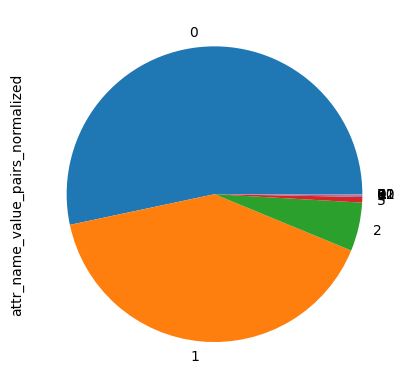

In [60]:
df_out.attr_name_value_pairs_normalized.apply(len).value_counts().plot.pie()

In [61]:
from sklearn.model_selection import train_test_split

In [66]:
df_out.loc[df_out.attr_name_value_pairs_normalized_text.apply(lambda x: len(x) == 0), "attr_name_value_pairs_normalized_text_addunk"] = 'unknown'
df_out.loc[df_out.attr_name_value_pairs_normalized_text.apply(lambda x: len(x) != 0), "attr_name_value_pairs_normalized_text_addunk"] = \
    df_out.loc[df_out.attr_name_value_pairs_normalized_text.apply(lambda x: len(x) != 0), "attr_name_value_pairs_normalized_text"]

/tmp/ipykernel_30170/2133343903.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out.loc[df_out.attr_name_value_pairs_normalized_text.apply(lambda x: len(x) == 0), "attr_name_value_pairs_normalized_text_addunk"] = 'unknown'


In [68]:
train, _ = train_test_split(df_out, test_size=.2, random_state=42)
val, test = train_test_split(_, test_size=0.5, random_state=42)

In [69]:
len(train), len(val), len(test)

(259204, 32400, 32401)

In [70]:
train.to_json('processed3/appen_all_validated_query_attr_train.json', lines=True, orient='records')
val.to_json('processed3/appen_all_validated_query_attr_val.json', lines=True, orient='records')
test.to_json('processed3/appen_all_validated_query_attr_test.json', lines=True, orient='records')